This notebook consists of following sections:

1. Importing libraries and checking on GPU
2. Explanatory Data Analysis
3. Defining functions to be used in the main body
4. Main Body (LSTM)
5. Main Body (LSTM Autoencoder)
6. Main Body (LSTM Cross-Validation)
7. Main Body (Ensemble Method)

# Importing libraries and checking on GPU

In [1]:
# Importing all necessary library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.python import keras

from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras import backend as K
from keras.layers import Dense, Embedding, SimpleRNN
from keras.models import Sequential

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

!pip install -U yfinance
import yfinance as yf

from google.colab import drive
drive.mount('/drive')

tf.random.set_seed(100)
import os
os.environ['PYTHONHASHSEED'] = '0'

import timeit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /drive


In [3]:
# Checking if GPU available in our system

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
# Compare if the GPU is faster than CPU in the system, the perform operation with GPU for specific code

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
8.77602004900001
GPU (s):
0.1627986480000061
GPU speedup over CPU: 53x


# Explanatory Data Analysis

In [2]:
def download_stock_data(start_date = '20080101', end_date = '20221231', symbols = ["AMZN", "AAPL", "MSFT", "GOOGL", "NVDA"]):
  """
  Download the stock data for AMZN, AAPL, MSFT, GOOGL, NVDA
  """
  # Define the stock Start and End Date (15 years)

  start = pd.to_datetime(start_date, format='%Y%m%d')
  end = pd.to_datetime(end_date, format='%Y%m%d')
  days = (end-start).days

  # Create empty dataframe
  stocks = pd.DataFrame()

  #iterate over each symbol
  for symbol in symbols:
    print( str(symbols.index(symbol)) + str(' : ') + symbol, sep=',', end=',', flush=True)
    stock = []
    stock = yf.download(symbol, start=start, end=end, progress=False)
    stock['Name']=symbol
    stocks = pd.concat([stocks, stock], sort=False)

  print('total stock downloaded: ', stocks['Name'].nunique())

  # Uncomment this line if we want to save the stock file
  #stocks.to_csv('/drive/My Drive/Colab Notebooks/FML Coursework/stocks.csv')

  return stocks

stocks = download_stock_data('20080101', '20221231', symbols = ["AMZN", "AAPL", "MSFT", "GOOGL", "NVDA"])

0 : AMZN,1 : AAPL,2 : MSFT,3 : GOOGL,4 : NVDA,total stock downloaded:  5


In [3]:
def separate_stock_data(stocks):
  """
  Separate stocks data downloaded from Yahoo Finance into different dataframes.
  
  Input:
    stocks (dataframe): Stocks downloaded for the first time from Yahoo Finance

  Output:
    df_AMZN (dataframe): AMAZON stock
    df_AAPL (dataframe): AAPL stock
    df_MSFT (dataframe): MSFT stock
    df_GOOGL (dataframe): GOOGL stock
    df_NVDA (dataframe): NVDA stock
  """
  # Group the DataFrame by the "Name" column and create separate DataFrames for each group
  dfs = {group: group_df.drop(['Volume', 'Name'], axis=1) for group, group_df in stocks.groupby('Name')}

  window = 30
  # Assign names to each of the resulting DataFrames
  for name, group_df in dfs.items():
    group_df['ArithmeticReturn'] = group_df['Adj Close'].pct_change().rolling(window).mean()
    group_df['VOL'] = group_df['ArithmeticReturn'].rolling(window).std()
    globals()[f'df_{name}'] = group_df

  # Drop the first 59 rows with NaN values that we don't want to replace
  dataframes = [df_AMZN, df_AAPL, df_MSFT, df_GOOGL, df_NVDA]
  for df in dataframes:
    df.drop(df.index[:59], inplace=True)
  
  return df_AMZN, df_AAPL, df_MSFT, df_GOOGL, df_NVDA

df_AMZN, df_AAPL, df_MSFT, df_GOOGL, df_NVDA = separate_stock_data(stocks)

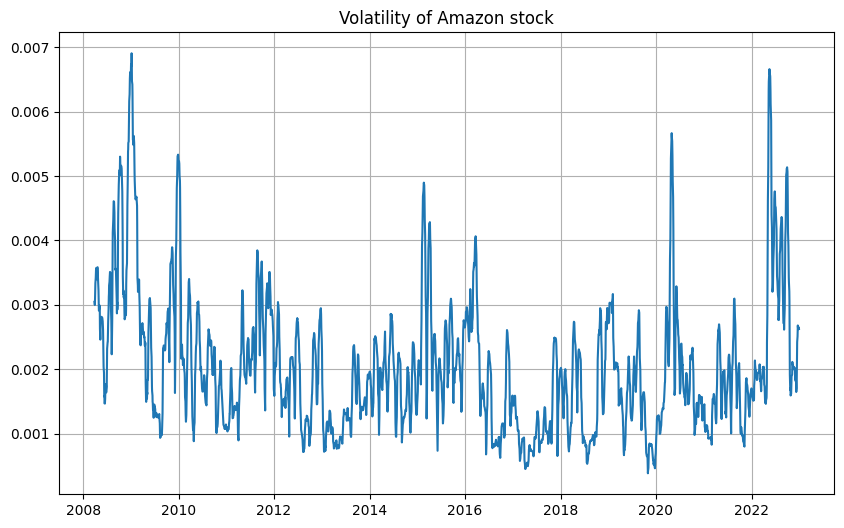

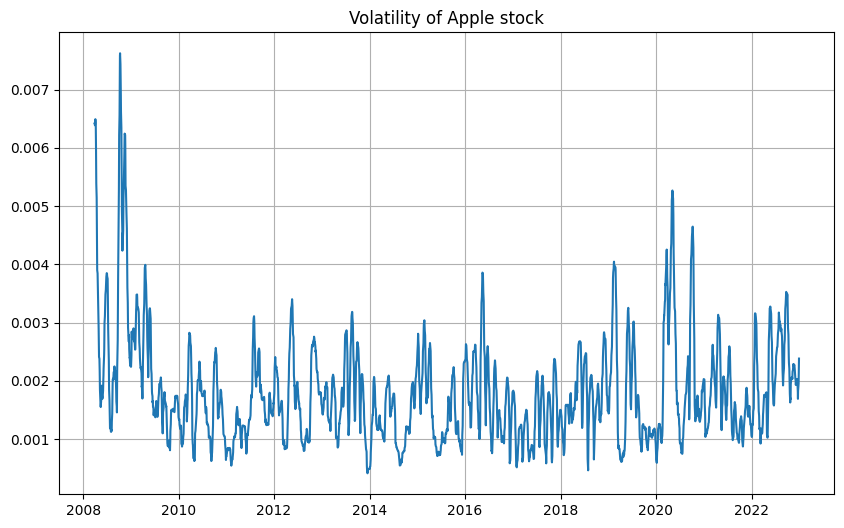

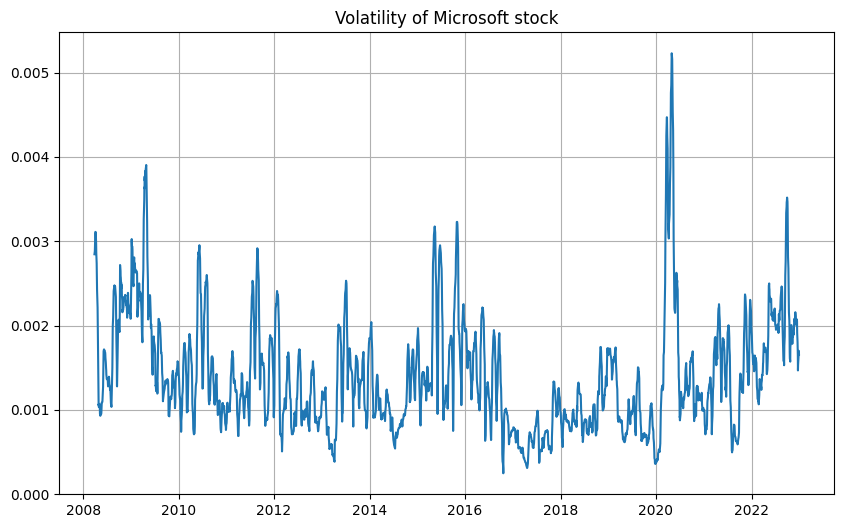

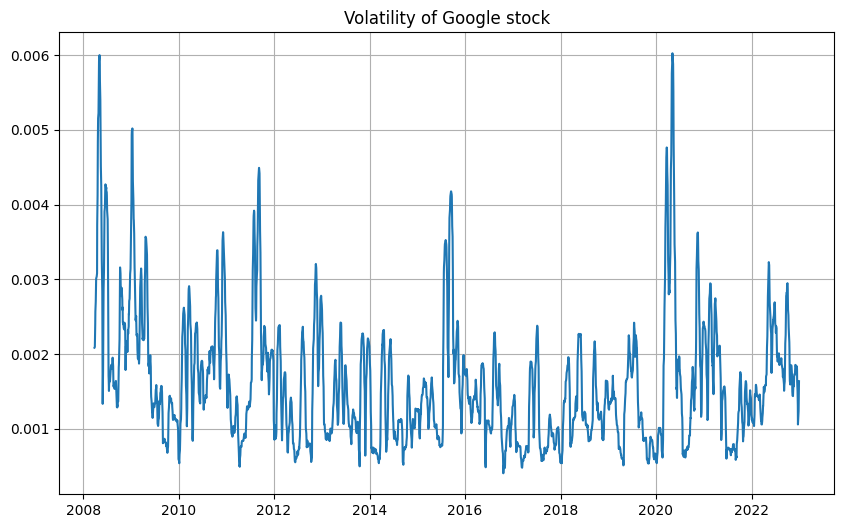

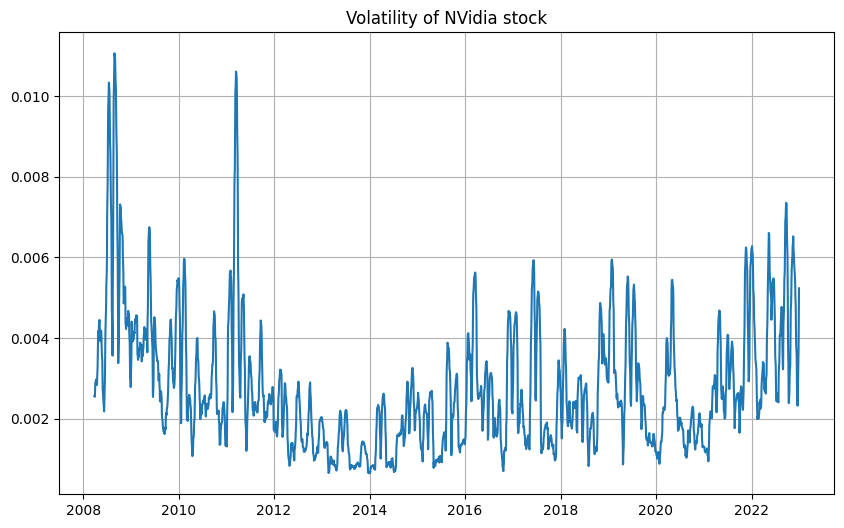

In [7]:
def plot_volatility(df, name):
  """
  Plot the volatility of stock. 
  """
  plt.figure(figsize = (10,6))
  plt.plot(df["VOL"], label='AMAZON')
  plt.grid()
  plt.title(f"Volatility of {name} stock")
  plt.show()

plot_volatility(df_AMZN, "Amazon")
plot_volatility(df_AAPL, "Apple")
plot_volatility(df_MSFT, "Microsoft")
plot_volatility(df_GOOGL, "Google")
plot_volatility(df_NVDA, "NVidia")

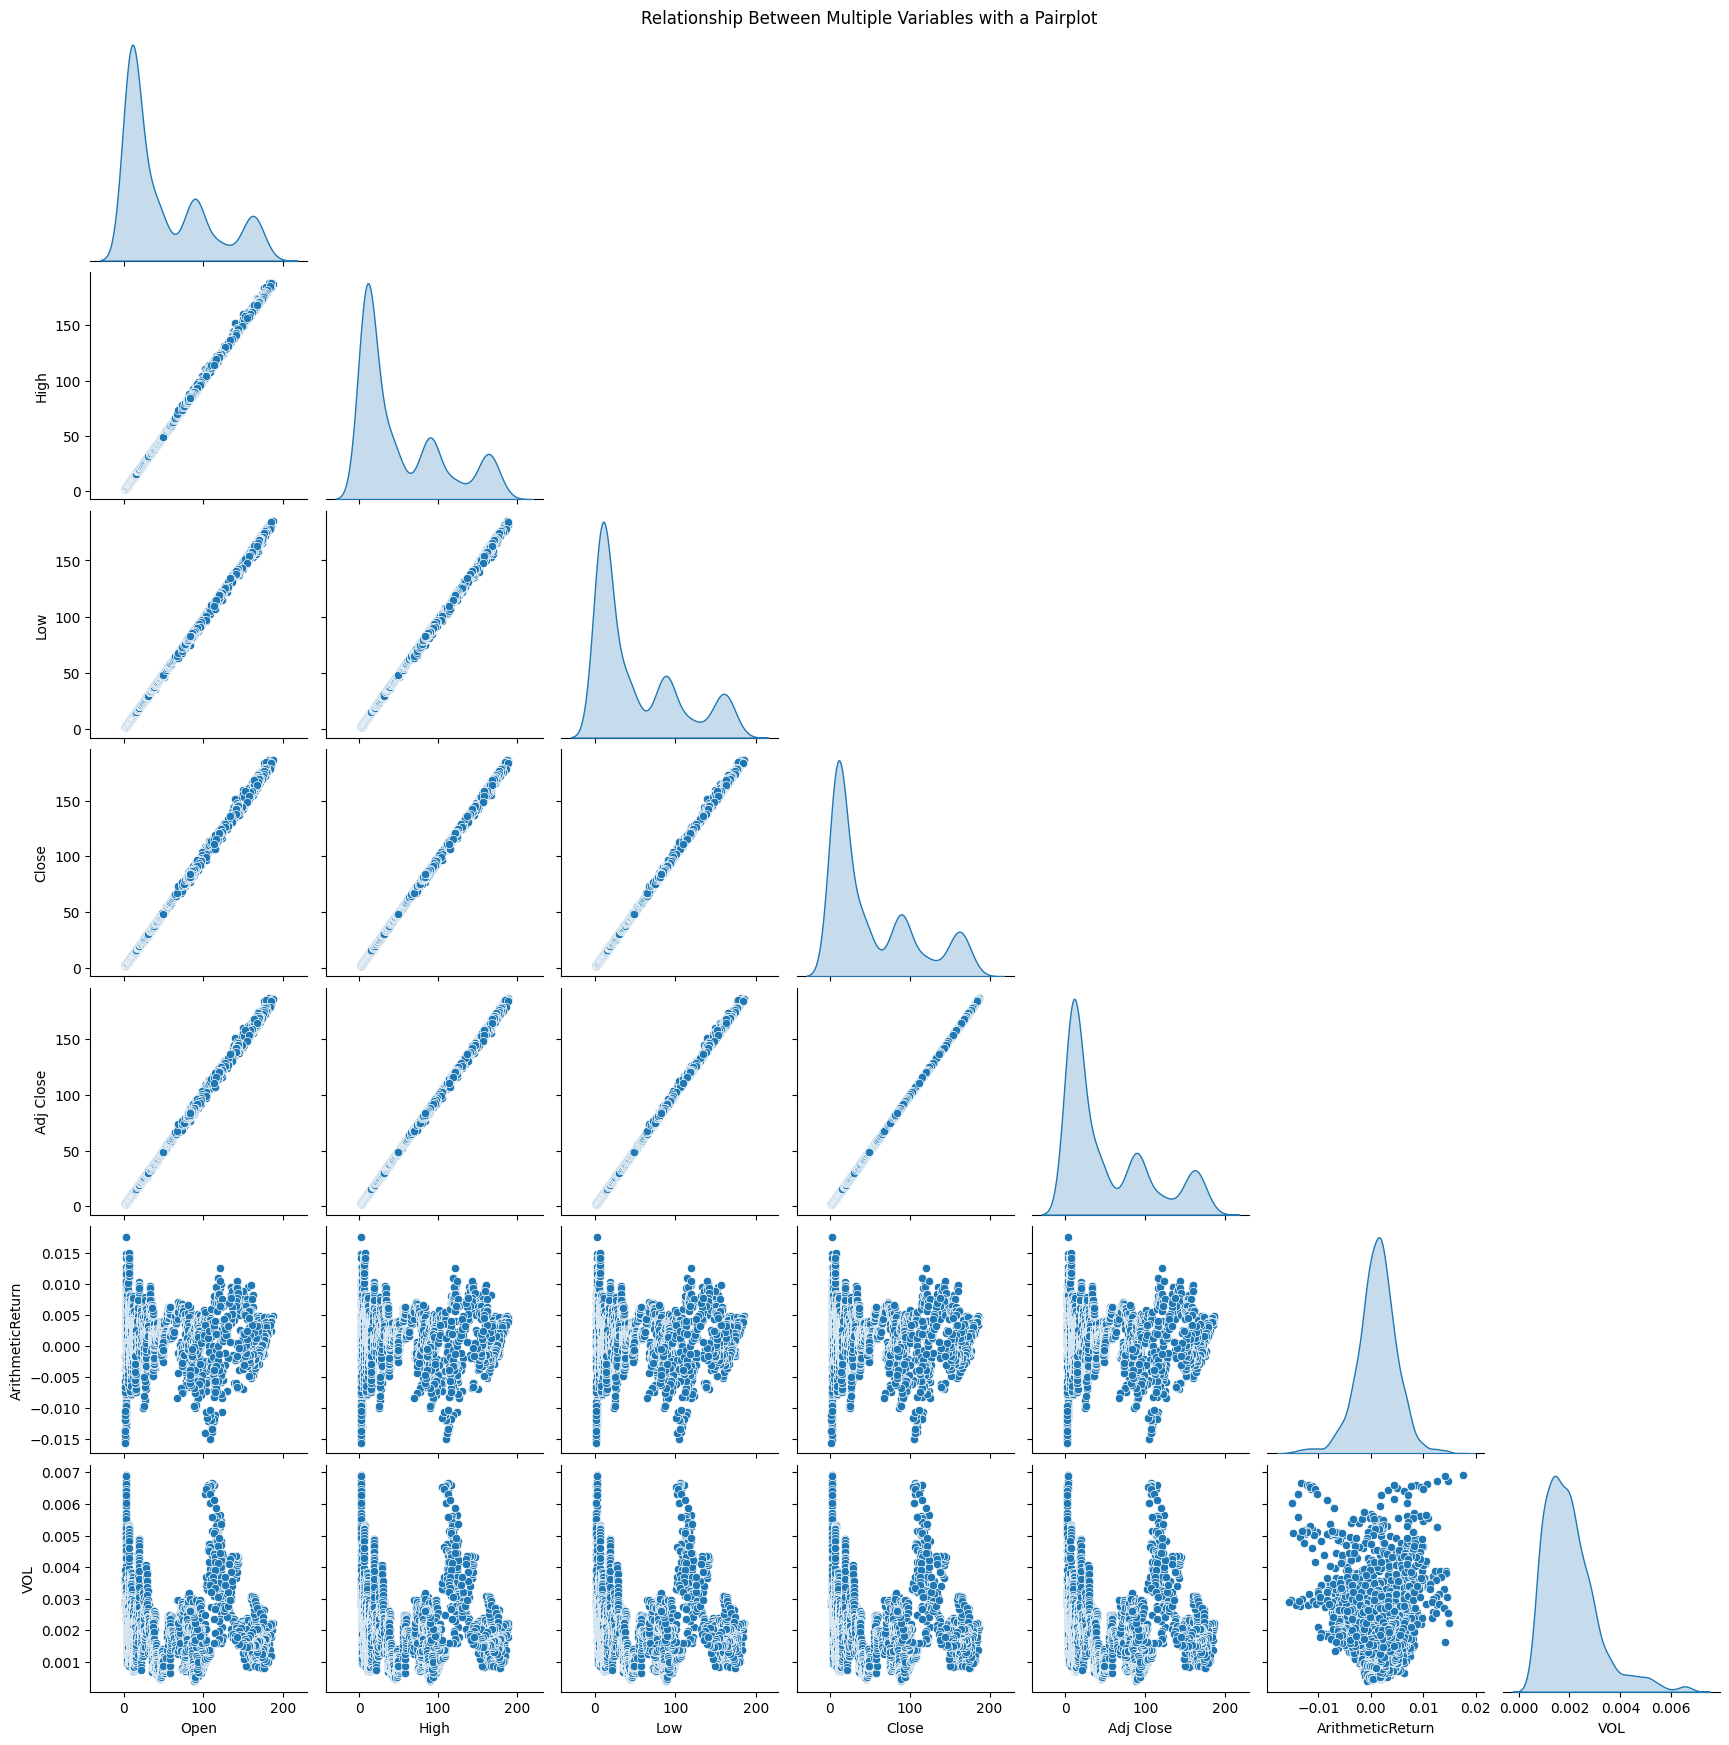

In [8]:
with tf.device('/device:GPU:0'):
  def plot_pairplot(features):
    """
    Showing the relationship between features for explanatory data analysis.

    Input:
      Features (DataFrame): Raw stock data.
      
    Output:
      Pairplot (Plot): The plot showing relationship between features.
    """
    g = sns.pairplot(features, kind="scatter", diag_kind = "kde", corner=True)
    g.fig.suptitle('Relationship Between Multiple Variables with a Pairplot', y=1)
    plt.show()
      
  plot_pairplot(df_AMZN)

# Defining functions to be used in the main body

In [4]:
def normalise_lstm_data(array_raw):
  """
  Normalise the stock array.
  """
  scaler = MinMaxScaler()
  array_lstm = scaler.fit_transform(array_raw)
  return array_lstm, scaler

def inverse_predictions(predictions, scaler, prediction_index=-1):
  '''
  This function uses the fitted scaler to inverse predictions, 
  the index should be set to the position of the target variable,
  in this case, the last column (volatility column).
  '''
  max_val = scaler.data_max_[prediction_index]
  min_val = scaler.data_min_[prediction_index]
  original_values = (predictions*(max_val - min_val )) + min_val
  return original_values

In [5]:
def split_training_test(array_lstm, look_back, horizon, num_periods):
  """
  The test set will be the last k (num_periods) periods we want test the model.
  In each period, the model will predict the next n coming days.
  The remaning data will be used for Train/Validation.
  Split train and test sets
  """
  division = len(array_lstm) - horizon*num_periods
  array_lstm_test = array_lstm[division-look_back:]
  array_lstm_train = array_lstm[:division]
  return array_lstm_test, array_lstm_train

In [6]:
def process_lstm_data(data, look_back, horizon, jump = 1):
  """
  Get the data and splits in input X and output Y, by spliting in `n` past days
  as input X and `m` coming days as Y.
  Jump is the next period we want to predict after each LSTM window.
  """
  X, Y = [],[]
  for i in range(0,len(data)-look_back-horizon+1, jump):
    # X contains seven features
    X.append(data[i:(i+look_back)])
    # Y only contains the volatility feature
    Y.append(data[(i+look_back):(i+look_back+horizon), -1])
  return np.array(X), np.array(Y)

In [8]:
def build_lstm(look_back, horizon, horizon_periods, X_train, y_train, X_validate, y_validate):
  """
  Build the the LSTM model.
  """
  NUM_NEURONS_FirstLayer = 64
  NUM_NEURONS_SecondLayer = 32
  EPOCHS = 50

  model = Sequential()
  model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back, X_train.shape[2]), return_sequences=True))
  model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
  model.add(Dense(horizon)) #Dense layer is to connect everything for regression
  model.compile(loss='mean_squared_error', optimizer='adam')

  early_stopping = EarlyStopping(monitor='val_loss', patience=10)

  history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate),shuffle=True,batch_size=1, verbose=2, callbacks=[early_stopping])

  return model, history

In [9]:
def lstm_autoencoder(df, latent_dim=6):
  """
  Extract the latent features equal to 'latent_dim' from LSTM Autoencoders,
  then run the LSTM with window=14 and horizon=7 to predict the volatility.

  Input:
    df(DataFrame): The dataframe of the stock of interest e.g. Amazon
    latent_dim(int): The latent dimension between 1 to 6

  Output:
    rmse(int): The RMSE score from volatility prediction using LSTM.
    plot(Matplotlib): The prediction plot.
  """
  window = 14
  horizon = 7
  horizon_periods = 30 # Meaning that we are trying to predict 7 * 100 rows

  array = df.values
  array_lstm, scaler = normalise_lstm_data(array)
  data = array_lstm

  x, y = process_lstm_data(data, window, horizon)

  # Split the training and test data
  array_lstm_test, array_lstm_train = split_training_test(array_lstm, window, horizon, horizon_periods)

  # Preprocessing the training data to make it suitable for LSTM 
  X, y = process_lstm_data(array_lstm_train, window, horizon)
  y = np.array([list(a.ravel()) for a in y])

  # Split the training data to 80% training and 20% validation
  X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=0, shuffle=False)

  # Preprocessing the test data to make it suitable for LSTM
  X_test, y_test = process_lstm_data(array_lstm_test, window, horizon, horizon)
  y_test = np.array([list(a.ravel()) for a in y_test])

  ### LSTM Autoencoder ###
  input_shape = (window, 7)
  encoder_inputs = Input(shape=input_shape)
  encoder = LSTM(latent_dim, return_sequences=True)(encoder_inputs)
  # Define decoder LSTM layer
  decoder = LSTM(7, return_sequences=True)(encoder)
  # Define RepeatVector layer to repeat the output of the encoder
  flatten_decoder = Flatten()(decoder)
  repeat = RepeatVector(window)(flatten_decoder)
  # Define TimeDistributed layer to apply a dense layer to each of the timesteps
  decoder_outputs = TimeDistributed(Dense(7))(repeat)
  # Define autoencoder model
  autoencoder = Model(encoder_inputs, decoder_outputs)
  # Compile the model
  autoencoder.compile(optimizer='adam', loss='mse')

  # Train the autoencoder model
  batch_size = 64
  num_epochs = 100
  es = EarlyStopping(monitor='val_loss', mode='auto', restore_best_weights=True, verbose=1, patience=10)
  autoencoder.fit(X_train, X_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test, X_test), callbacks=[es])

  # Use encoder to obtain encoded representation of input data
  encoder_model = Model(encoder_inputs, encoder)
  encoded_X_train = encoder_model.predict(X_train)
  encoded_X_test = encoder_model.predict(X_test)

  # Split the training data to 80% training and 20% validation
  X_train, X_validate, y_train, y_validate = train_test_split(encoded_X_train, y_train, test_size=0.20, random_state=0)
  model, history = build_lstm(window, horizon, horizon_periods, X_train, y_train, X_validate, y_validate)

  # Make predictions on test data
  test_pred = model.predict(encoded_X_test)

  # Inverse transform the data
  i_test_pred = scaler.inverse_transform(test_pred)
  i_y_test = scaler.inverse_transform(y_test)

  # Calculate RMSE score
  rmse = np.sqrt(mean_squared_error(i_y_test[-1], i_test_pred[-1]))
  print('RMSE score:', rmse)

  # Plot the data
  fig, ax = plt.subplots()
  ax.plot(i_y_test[:,-1], label="Target")
  ax.plot(i_test_pred[:,-1], label="Predicted")
  ax.set_xlabel('Time')
  ax.set_ylabel('Volatility')
  plt.legend()
  plt.title("Volatility forecasting of LSTM Autoencoder")
  plt.show()

  return rmse

In [10]:
def predict_stock(array_raw):
  """
  Evaluate stock using LSTM with different window and horizon.

  Input:
    array_raw (NumPy array): The raw stock data with seven features.

  Output:
    df_evaluation (DataFrame): The RMSE scores for 16 different combinations of
                               windows and horizons.
  """
  look_back_list = [7, 14, 21, 28]
  horizon_list = [7, 14, 21, 28]
  horizon_periods = 30

  df_evaluation = pd.DataFrame(columns=['Look back', 'Horizon', 'RMSE'])

  # Loop over four different look back and four different horizons, there will be 16 combination
  for look_back in look_back_list:

    for horizon in horizon_list:

      print(f"=====FORECASTING VOLATILITY WITH {look_back} DAYS WINDOW AND {horizon} DAYS HORIZON=====")

      # Normalise the stock array
      array_lstm, scaler = normalise_lstm_data(array_raw)

      # Split the training and test data
      array_lstm_test, array_lstm_train = split_training_test(array_lstm, look_back, horizon, horizon_periods)

      # Preprocessing the training data to make it suitable for LSTM 
      X, y = process_lstm_data(array_lstm_train, look_back, horizon)
      y = np.array([list(a.ravel()) for a in y])

      # Split the training data to 80% training and 20% validation
      X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=0, shuffle=False)

      # Preprocessing the test data to make it suitable for LSTM
      X_test, y_test = process_lstm_data(array_lstm_test, look_back, horizon, horizon)
      y_test = np.array([list(a.ravel()) for a in y_test])

      # Build the LSTM model
      model, history = build_lstm(look_back, horizon, horizon_periods, X_train, y_train, X_validate, y_validate)

      # Showing the learning curve
      plt.figure(figsize = (10, 6))
      plt.plot(history.history['loss'], label='loss')
      plt.plot(history.history['val_loss'], label='val_loss')
      plt.legend(loc='best')
      plt.show()

      # Predict the 
      y_pred_test = model.predict(X_test)

      # Get the original values for volatility prediction
      y_pred = []
      for i in range(horizon_periods):
        inverse = inverse_predictions(y_pred_test[i], scaler, -1)
        y_pred.append(inverse)
      y_pred = np.array(y_pred)

      # Get the original values for volatility in test set
      y_test_inverse = []
      for i in range(horizon_periods):
        inverse = inverse_predictions(y_test[i], scaler, -1)
        y_test_inverse.append(inverse)
      y_test_inverse = np.array(y_test_inverse)

      # Showing prediction vs target
      plt.figure(figsize = (10, 6))
      for i in range(0,len(y_pred_test)):
        plt.plot([x + i*horizon for x in range(len(y_pred[i]))], y_pred[i].reshape(-1,1), color='r')
      plt.plot(0, y_pred[i].reshape(-1,1)[0], color='r', label='Prediction') #only to place the label 
      plt.plot(y_test_inverse.reshape(-1,1), label='Target')
      plt.legend(loc='best')
      plt.show()

      # Calculating RMSE
      rmse = mean_squared_error(y_test_inverse, y_pred, squared=False)

      print(f"For look back window:{look_back}, forward days/horizon:{horizon}, the RMSE is: {rmse}")

      # Save the RMSE values to a dataframe
      df_evaluation.loc[len(df_evaluation)] = [look_back, horizon, rmse]
      print(df_evaluation)

  return df_evaluation

In [11]:
def lstm_cross_validation(feature_matrix):
  """
  Do the 10-folds cross validation test with LSTM.
  The output will be used as comparison with other models in box plot.

  Input:
    feature_matrix (DataFrame): The raw data of the stock.

  Output:
    all_rmse (list): The list of RMSE for all folds.
  """

  # The variable to forecast
  forecasting_variable = feature_matrix.iloc[:, -1]

  scaler = MinMaxScaler()
  feature_matrix = pd.DataFrame(scaler.fit_transform(feature_matrix))

  tscv = TimeSeriesSplit(n_splits=10)
  print(tscv)
  print(62*'#')

  # Set a list to save the rmse for all folds
  all_rmse = []
  counter = 0
  
  for train_index, test_index in tscv.split(feature_matrix):

    counter += 1
    print('Fold %d:' %counter)

    print("TRAIN:", len(train_index), "TEST:", len(test_index))

    X_train, X_test = feature_matrix.iloc[train_index,:], feature_matrix.iloc[test_index,:]
    Y_train, Y_test = forecasting_variable.iloc[train_index], forecasting_variable.iloc[test_index]
    print(70*'-')

    # Prepare LSTM data - 3D Inputs of the format [samples, lookback period, features]
    #----------------------------------------------------------------------
    # Train Set 
    #----------------------------------------------------------------------

    X_train_to_Numpy = pd.DataFrame(X_train).to_numpy()
    Y_train_to_Numpy = pd.DataFrame(Y_train).to_numpy()

    look_back = 14
    x_train_append_matrix = []
    y_train_append_matrix = []

    for i in range(len(X_train)-look_back):
        feat_current_train = X_train_to_Numpy[i:i+look_back, :]
        label_current_train = Y_train_to_Numpy[i+look_back]
        x_train_append_matrix.append(feat_current_train)
        y_train_append_matrix.append(label_current_train)

    X_train_numpy = np.array(x_train_append_matrix)
    Y_train_numpy = np.array(y_train_append_matrix)

    #----------------------------------------------------------------------
    # Test Set 
    #----------------------------------------------------------------------
    Y_test = Y_test.values.reshape(-1,1)

    X_test_to_Numpy = pd.DataFrame(X_test).to_numpy()
    Y_test_to_Numpy = pd.DataFrame(Y_test).to_numpy()

    #----------------------------------------------------------------------
    # Build LSTM
    #----------------------------------------------------------------------
    NUM_NEURONS_FirstLayer = 64
    NUM_NEURONS_SecondLayer = 32
    EPOCHS = 50
    forward_days = 1

    #Build the model
    model = Sequential()
    model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back, X_train_numpy.shape[2]), return_sequences=True))
    model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
    model.add(Dense(forward_days))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    # Fit model with history to check for overfitting
    history = model.fit(X_train_numpy, Y_train_numpy, epochs=EPOCHS, batch_size = 1, validation_split = 0.2, shuffle=False, verbose=3, callbacks=[early_stopping])

    x_test_append_matrix = []
    y_test_append_matrix = []

    for i in range(len(X_test)-look_back):         
        feat_current_test = X_test_to_Numpy[i:i+look_back, :]
        label_current_test = Y_test_to_Numpy[i+look_back]
        x_test_append_matrix.append(feat_current_test)
        y_test_append_matrix.append(label_current_test)

    X_test_numpy = np.array(x_test_append_matrix)
    Y_test_numpy = np.array(y_test_append_matrix)

    Y_test_inverse = inverse_predictions(Y_test_numpy, scaler, prediction_index=-1)

    Y_pred = model.predict(X_test_numpy)
    Y_pred_inverse = inverse_predictions(Y_pred, scaler, prediction_index=-1)

    rmse = mean_squared_error(Y_test_numpy, Y_pred_inverse, squared=False)
    print('testScore:', rmse)

    all_rmse.append(rmse)

  return all_rmse

In [12]:
def xgboost_cross_validation(feature_matrix):
  """
  Do the 10-folds cross validation test with XGBoost.
  The output will be used as comparison with LSTM model in box plot.

  Input:
    feature_matrix (DataFrame): The raw data of the stock.

  Output:
    all_rmse (list): The list of RMSE for all folds.
  """

  # The variable to forecast
  forecasting_variable = feature_matrix.iloc[:, -1]

  scaler = MinMaxScaler()
  feature_matrix = pd.DataFrame(scaler.fit_transform(feature_matrix))

  tscv = TimeSeriesSplit(n_splits=10)
  print(tscv)
  print(62*'#')

  # Set a list to save the rmse for all folds
  all_rmse = []
  counter = 0
  
  for train_index, test_index in tscv.split(feature_matrix):

    counter += 1
    print('Fold %d:' %counter)

    print("TRAIN:", len(train_index), "TEST:", len(test_index))

    X_train, X_test = feature_matrix.iloc[train_index,:], feature_matrix.iloc[test_index,:]
    y_train, y_test = forecasting_variable.iloc[train_index], forecasting_variable.iloc[test_index]
    print(70*'-')

    #Build the model
    model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)

    # Fit model with history to check for overfitting
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    Y_pred_inverse = inverse_predictions(y_pred, scaler, -1)
    Y_test_numpy = np.array(y_test)

    rmse = mean_squared_error(Y_test_numpy, Y_pred_inverse, squared=False)
    print('testScore:', rmse)

    all_rmse.append(rmse)

  return all_rmse

In [13]:
def randomforest_cross_validation(feature_matrix):
  """
  Do the 10-folds cross validation test with XGBoost.
  The output will be used as comparison with LSTM model in box plot.

  Input:
    feature_matrix (DataFrame): The raw data of the stock.

  Output:
    all_rmse (list): The list of RMSE for all folds.
  """

  # The variable to forecast
  forecasting_variable = feature_matrix.iloc[:, -1]

  scaler = MinMaxScaler()
  feature_matrix = pd.DataFrame(scaler.fit_transform(feature_matrix))

  tscv = TimeSeriesSplit(n_splits=10)
  print(tscv)
  print(62*'#')

  # Set a list to save the rmse for all folds
  all_rmse = []
  counter = 0
  
  for train_index, test_index in tscv.split(feature_matrix):

    counter += 1
    print('Fold %d:' %counter)

    print("TRAIN:", len(train_index), "TEST:", len(test_index))

    X_train, X_test = feature_matrix.iloc[train_index,:], feature_matrix.iloc[test_index,:]
    y_train, y_test = forecasting_variable.iloc[train_index], forecasting_variable.iloc[test_index]
    print(70*'-')

    #Build the model
    model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Fit model with history to check for overfitting
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    Y_pred_inverse = inverse_predictions(y_pred, scaler, -1)
    Y_test_numpy = np.array(y_test)

    rmse = mean_squared_error(Y_test_numpy, Y_pred_inverse, squared=False)
    print('testScore:', rmse)

    all_rmse.append(rmse)

  return all_rmse

# Main Body (LSTM)

=====FORECASTING VOLATILITY WITH 7 DAYS WINDOW AND 7 DAYS HORIZON=====
Epoch 1/50
2796/2796 - 17s - loss: 0.0086 - val_loss: 0.0043 - 17s/epoch - 6ms/step
Epoch 2/50
2796/2796 - 13s - loss: 0.0040 - val_loss: 0.0035 - 13s/epoch - 5ms/step
Epoch 3/50
2796/2796 - 12s - loss: 0.0031 - val_loss: 0.0028 - 12s/epoch - 4ms/step
Epoch 4/50
2796/2796 - 12s - loss: 0.0029 - val_loss: 0.0022 - 12s/epoch - 4ms/step
Epoch 5/50
2796/2796 - 12s - loss: 0.0028 - val_loss: 0.0030 - 12s/epoch - 4ms/step
Epoch 6/50
2796/2796 - 13s - loss: 0.0027 - val_loss: 0.0023 - 13s/epoch - 4ms/step
Epoch 7/50
2796/2796 - 13s - loss: 0.0026 - val_loss: 0.0021 - 13s/epoch - 5ms/step
Epoch 8/50
2796/2796 - 13s - loss: 0.0025 - val_loss: 0.0026 - 13s/epoch - 5ms/step
Epoch 9/50
2796/2796 - 13s - loss: 0.0025 - val_loss: 0.0021 - 13s/epoch - 5ms/step
Epoch 10/50
2796/2796 - 12s - loss: 0.0024 - val_loss: 0.0020 - 12s/epoch - 4ms/step
Epoch 11/50
2796/2796 - 12s - loss: 0.0023 - val_loss: 0.0027 - 12s/epoch - 4ms/step
Epo

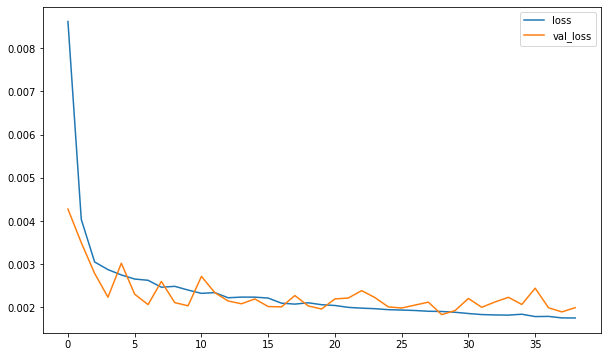

1/1 [==============================] - 1s 759ms/step


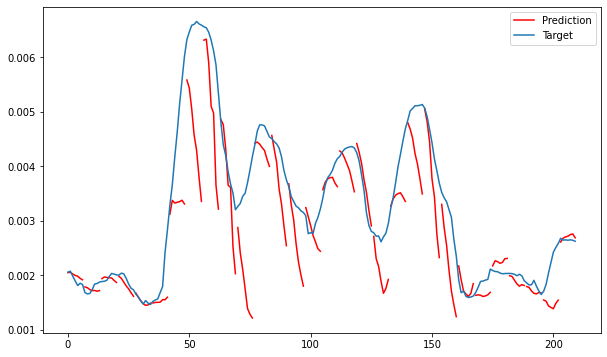

For look back window:7, forward days/horizon:7, the RMSE is: 0.0007211525648210467
   Look back  Horizon      RMSE
0        7.0      7.0  0.000721
=====FORECASTING VOLATILITY WITH 7 DAYS WINDOW AND 14 DAYS HORIZON=====
Epoch 1/50
2622/2622 - 15s - loss: 0.0134 - val_loss: 0.0113 - 15s/epoch - 6ms/step
Epoch 2/50
2622/2622 - 12s - loss: 0.0093 - val_loss: 0.0087 - 12s/epoch - 4ms/step
Epoch 3/50
2622/2622 - 12s - loss: 0.0076 - val_loss: 0.0068 - 12s/epoch - 4ms/step
Epoch 4/50
2622/2622 - 12s - loss: 0.0072 - val_loss: 0.0065 - 12s/epoch - 4ms/step
Epoch 5/50
2622/2622 - 12s - loss: 0.0068 - val_loss: 0.0061 - 12s/epoch - 4ms/step
Epoch 6/50
2622/2622 - 12s - loss: 0.0067 - val_loss: 0.0056 - 12s/epoch - 4ms/step
Epoch 7/50
2622/2622 - 12s - loss: 0.0063 - val_loss: 0.0059 - 12s/epoch - 5ms/step
Epoch 8/50
2622/2622 - 12s - loss: 0.0061 - val_loss: 0.0058 - 12s/epoch - 5ms/step
Epoch 9/50
2622/2622 - 12s - loss: 0.0060 - val_loss: 0.0054 - 12s/epoch - 4ms/step
Epoch 10/50
2622/2622 - 1

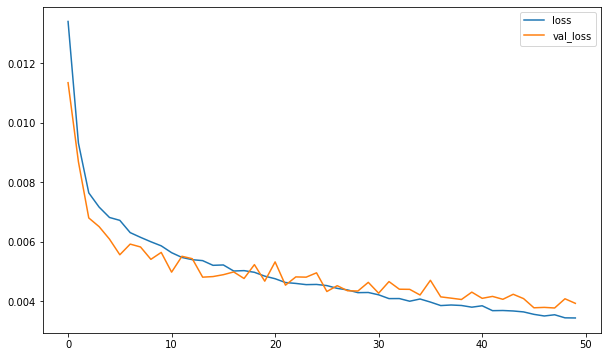

1/1 [==============================] - 1s 777ms/step


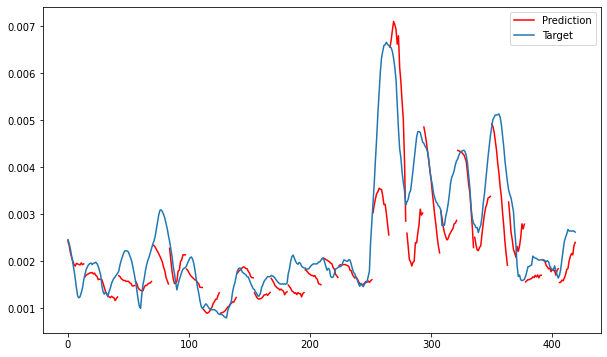

For look back window:7, forward days/horizon:14, the RMSE is: 0.0007227032950252729
   Look back  Horizon      RMSE
0        7.0      7.0  0.000721
1        7.0     14.0  0.000723
=====FORECASTING VOLATILITY WITH 7 DAYS WINDOW AND 21 DAYS HORIZON=====
Epoch 1/50
2448/2448 - 14s - loss: 0.0160 - val_loss: 0.0116 - 14s/epoch - 6ms/step
Epoch 2/50
2448/2448 - 11s - loss: 0.0131 - val_loss: 0.0107 - 11s/epoch - 4ms/step
Epoch 3/50
2448/2448 - 11s - loss: 0.0113 - val_loss: 0.0129 - 11s/epoch - 4ms/step
Epoch 4/50
2448/2448 - 11s - loss: 0.0105 - val_loss: 0.0108 - 11s/epoch - 4ms/step
Epoch 5/50
2448/2448 - 11s - loss: 0.0101 - val_loss: 0.0090 - 11s/epoch - 4ms/step
Epoch 6/50
2448/2448 - 11s - loss: 0.0098 - val_loss: 0.0089 - 11s/epoch - 4ms/step
Epoch 7/50
2448/2448 - 11s - loss: 0.0092 - val_loss: 0.0089 - 11s/epoch - 4ms/step
Epoch 8/50
2448/2448 - 11s - loss: 0.0090 - val_loss: 0.0090 - 11s/epoch - 4ms/step
Epoch 9/50
2448/2448 - 11s - loss: 0.0088 - val_loss: 0.0093 - 11s/epoch - 4

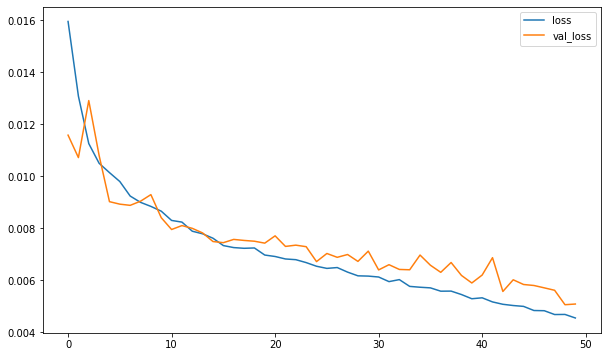

1/1 [==============================] - 1s 854ms/step


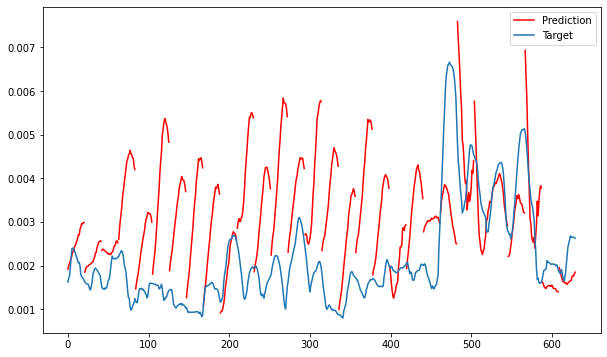

For look back window:7, forward days/horizon:21, the RMSE is: 0.001686376875382967
   Look back  Horizon      RMSE
0        7.0      7.0  0.000721
1        7.0     14.0  0.000723
2        7.0     21.0  0.001686
=====FORECASTING VOLATILITY WITH 7 DAYS WINDOW AND 28 DAYS HORIZON=====
Epoch 1/50
2275/2275 - 14s - loss: 0.0158 - val_loss: 0.0131 - 14s/epoch - 6ms/step
Epoch 2/50
2275/2275 - 10s - loss: 0.0136 - val_loss: 0.0131 - 10s/epoch - 4ms/step
Epoch 3/50
2275/2275 - 10s - loss: 0.0124 - val_loss: 0.0112 - 10s/epoch - 4ms/step
Epoch 4/50
2275/2275 - 10s - loss: 0.0119 - val_loss: 0.0107 - 10s/epoch - 4ms/step
Epoch 5/50
2275/2275 - 10s - loss: 0.0112 - val_loss: 0.0108 - 10s/epoch - 4ms/step
Epoch 6/50
2275/2275 - 10s - loss: 0.0108 - val_loss: 0.0112 - 10s/epoch - 4ms/step
Epoch 7/50
2275/2275 - 10s - loss: 0.0103 - val_loss: 0.0101 - 10s/epoch - 4ms/step
Epoch 8/50
2275/2275 - 10s - loss: 0.0098 - val_loss: 0.0096 - 10s/epoch - 4ms/step
Epoch 9/50
2275/2275 - 10s - loss: 0.0094 - v

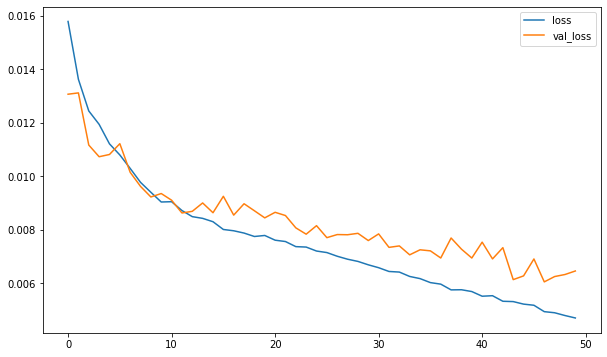

1/1 [==============================] - 1s 782ms/step


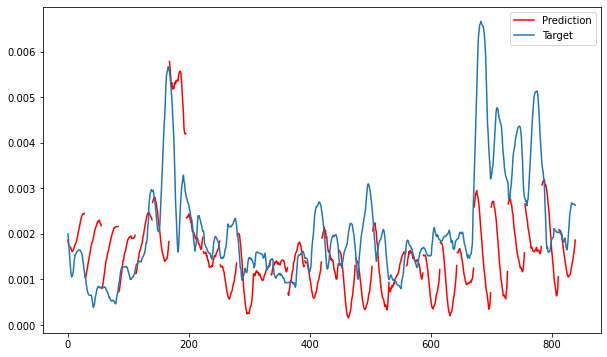

For look back window:7, forward days/horizon:28, the RMSE is: 0.0012963300152169291
   Look back  Horizon      RMSE
0        7.0      7.0  0.000721
1        7.0     14.0  0.000723
2        7.0     21.0  0.001686
3        7.0     28.0  0.001296
=====FORECASTING VOLATILITY WITH 14 DAYS WINDOW AND 7 DAYS HORIZON=====
Epoch 1/50
2790/2790 - 17s - loss: 0.0080 - val_loss: 0.0034 - 17s/epoch - 6ms/step
Epoch 2/50
2790/2790 - 13s - loss: 0.0035 - val_loss: 0.0027 - 13s/epoch - 5ms/step
Epoch 3/50
2790/2790 - 13s - loss: 0.0029 - val_loss: 0.0026 - 13s/epoch - 5ms/step
Epoch 4/50
2790/2790 - 13s - loss: 0.0027 - val_loss: 0.0029 - 13s/epoch - 5ms/step
Epoch 5/50
2790/2790 - 13s - loss: 0.0025 - val_loss: 0.0031 - 13s/epoch - 5ms/step
Epoch 6/50
2790/2790 - 13s - loss: 0.0025 - val_loss: 0.0022 - 13s/epoch - 5ms/step
Epoch 7/50
2790/2790 - 13s - loss: 0.0024 - val_loss: 0.0023 - 13s/epoch - 5ms/step
Epoch 8/50
2790/2790 - 13s - loss: 0.0023 - val_loss: 0.0021 - 13s/epoch - 5ms/step
Epoch 9/50
2

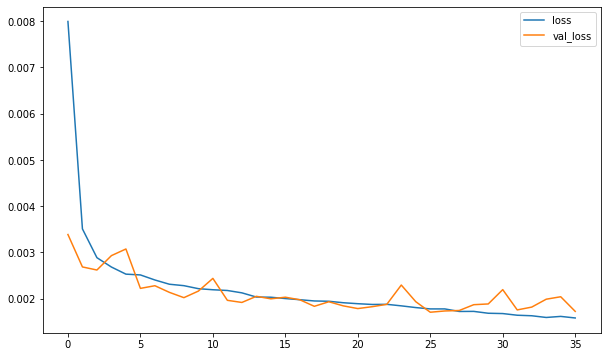

1/1 [==============================] - 2s 2s/step


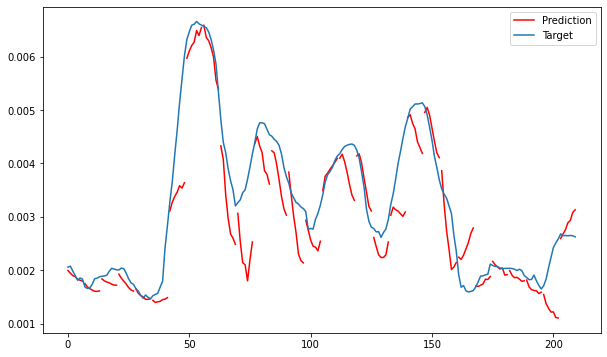

For look back window:14, forward days/horizon:7, the RMSE is: 0.0005524722427182998
   Look back  Horizon      RMSE
0        7.0      7.0  0.000721
1        7.0     14.0  0.000723
2        7.0     21.0  0.001686
3        7.0     28.0  0.001296
4       14.0      7.0  0.000552
=====FORECASTING VOLATILITY WITH 14 DAYS WINDOW AND 14 DAYS HORIZON=====
Epoch 1/50
2616/2616 - 16s - loss: 0.0127 - val_loss: 0.0080 - 16s/epoch - 6ms/step
Epoch 2/50
2616/2616 - 12s - loss: 0.0085 - val_loss: 0.0065 - 12s/epoch - 5ms/step
Epoch 3/50
2616/2616 - 12s - loss: 0.0071 - val_loss: 0.0071 - 12s/epoch - 5ms/step
Epoch 4/50
2616/2616 - 12s - loss: 0.0068 - val_loss: 0.0058 - 12s/epoch - 5ms/step
Epoch 5/50
2616/2616 - 12s - loss: 0.0062 - val_loss: 0.0062 - 12s/epoch - 5ms/step
Epoch 6/50
2616/2616 - 12s - loss: 0.0060 - val_loss: 0.0053 - 12s/epoch - 5ms/step
Epoch 7/50
2616/2616 - 12s - loss: 0.0057 - val_loss: 0.0051 - 12s/epoch - 5ms/step
Epoch 8/50
2616/2616 - 12s - loss: 0.0055 - val_loss: 0.0049 - 

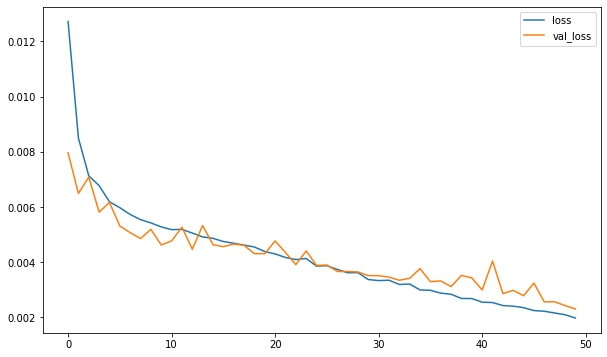

1/1 [==============================] - 1s 808ms/step


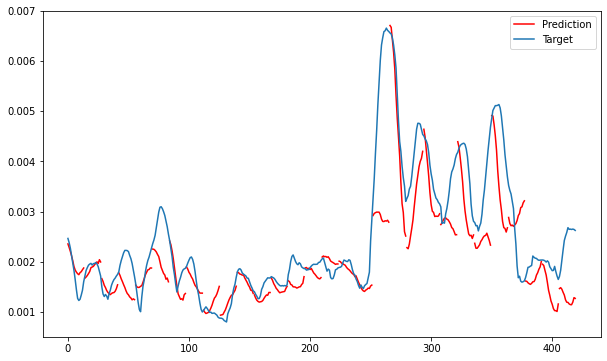

For look back window:14, forward days/horizon:14, the RMSE is: 0.0007664296884197788
   Look back  Horizon      RMSE
0        7.0      7.0  0.000721
1        7.0     14.0  0.000723
2        7.0     21.0  0.001686
3        7.0     28.0  0.001296
4       14.0      7.0  0.000552
5       14.0     14.0  0.000766
=====FORECASTING VOLATILITY WITH 14 DAYS WINDOW AND 21 DAYS HORIZON=====
Epoch 1/50
2443/2443 - 15s - loss: 0.0155 - val_loss: 0.0117 - 15s/epoch - 6ms/step
Epoch 2/50
2443/2443 - 11s - loss: 0.0116 - val_loss: 0.0108 - 11s/epoch - 5ms/step
Epoch 3/50
2443/2443 - 11s - loss: 0.0105 - val_loss: 0.0096 - 11s/epoch - 5ms/step
Epoch 4/50
2443/2443 - 11s - loss: 0.0096 - val_loss: 0.0089 - 11s/epoch - 4ms/step
Epoch 5/50
2443/2443 - 11s - loss: 0.0092 - val_loss: 0.0095 - 11s/epoch - 4ms/step
Epoch 6/50
2443/2443 - 11s - loss: 0.0087 - val_loss: 0.0082 - 11s/epoch - 5ms/step
Epoch 7/50
2443/2443 - 11s - loss: 0.0081 - val_loss: 0.0082 - 11s/epoch - 5ms/step
Epoch 8/50
2443/2443 - 11s - l

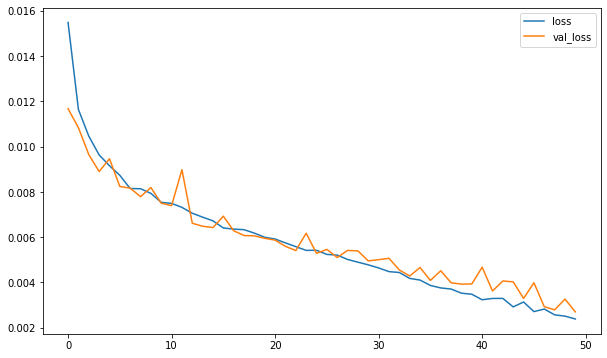

1/1 [==============================] - 1s 727ms/step


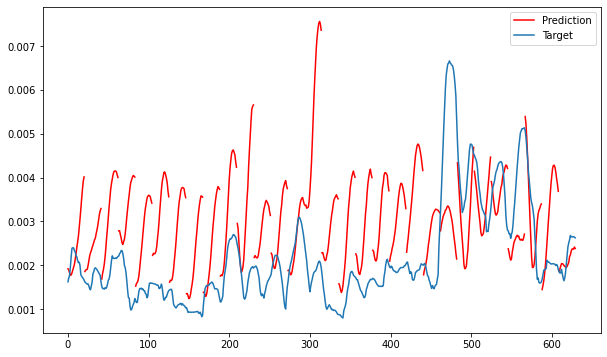

For look back window:14, forward days/horizon:21, the RMSE is: 0.001516445263326248
   Look back  Horizon      RMSE
0        7.0      7.0  0.000721
1        7.0     14.0  0.000723
2        7.0     21.0  0.001686
3        7.0     28.0  0.001296
4       14.0      7.0  0.000552
5       14.0     14.0  0.000766
6       14.0     21.0  0.001516
=====FORECASTING VOLATILITY WITH 14 DAYS WINDOW AND 28 DAYS HORIZON=====
Epoch 1/50
2269/2269 - 16s - loss: 0.0158 - val_loss: 0.0129 - 16s/epoch - 7ms/step
Epoch 2/50
2269/2269 - 11s - loss: 0.0131 - val_loss: 0.0120 - 11s/epoch - 5ms/step
Epoch 3/50
2269/2269 - 11s - loss: 0.0118 - val_loss: 0.0115 - 11s/epoch - 5ms/step
Epoch 4/50
2269/2269 - 10s - loss: 0.0108 - val_loss: 0.0096 - 10s/epoch - 5ms/step
Epoch 5/50
2269/2269 - 10s - loss: 0.0100 - val_loss: 0.0095 - 10s/epoch - 4ms/step
Epoch 6/50
2269/2269 - 10s - loss: 0.0094 - val_loss: 0.0099 - 10s/epoch - 5ms/step
Epoch 7/50
2269/2269 - 10s - loss: 0.0091 - val_loss: 0.0086 - 10s/epoch - 5ms/step

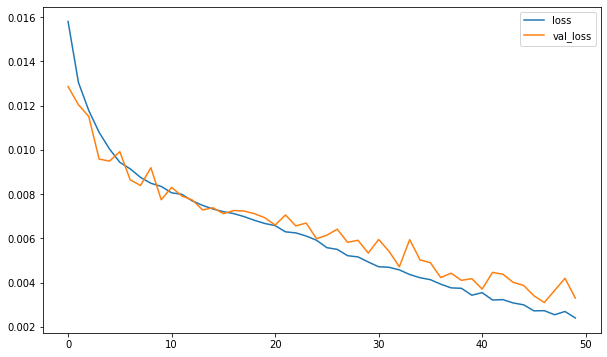

1/1 [==============================] - 1s 864ms/step


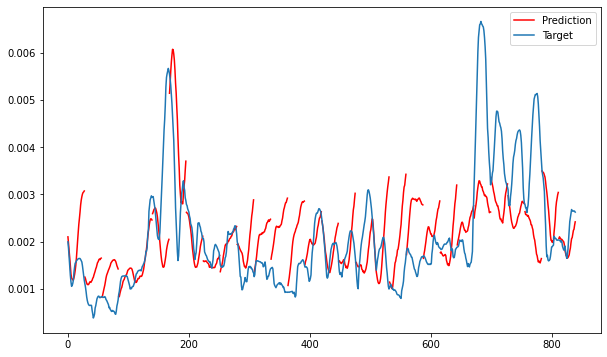

For look back window:14, forward days/horizon:28, the RMSE is: 0.0010173171322163707
   Look back  Horizon      RMSE
0        7.0      7.0  0.000721
1        7.0     14.0  0.000723
2        7.0     21.0  0.001686
3        7.0     28.0  0.001296
4       14.0      7.0  0.000552
5       14.0     14.0  0.000766
6       14.0     21.0  0.001516
7       14.0     28.0  0.001017
=====FORECASTING VOLATILITY WITH 21 DAYS WINDOW AND 7 DAYS HORIZON=====
Epoch 1/50
2784/2784 - 17s - loss: 0.0079 - val_loss: 0.0035 - 17s/epoch - 6ms/step
Epoch 2/50
2784/2784 - 13s - loss: 0.0036 - val_loss: 0.0027 - 13s/epoch - 5ms/step
Epoch 3/50
2784/2784 - 14s - loss: 0.0029 - val_loss: 0.0023 - 14s/epoch - 5ms/step
Epoch 4/50
2784/2784 - 14s - loss: 0.0026 - val_loss: 0.0028 - 14s/epoch - 5ms/step
Epoch 5/50
2784/2784 - 14s - loss: 0.0026 - val_loss: 0.0022 - 14s/epoch - 5ms/step
Epoch 6/50
2784/2784 - 14s - loss: 0.0024 - val_loss: 0.0020 - 14s/epoch - 5ms/step
Epoch 7/50
2784/2784 - 14s - loss: 0.0024 - val_los

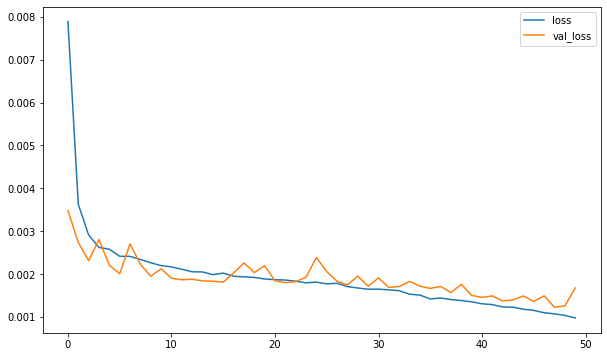

1/1 [==============================] - 1s 774ms/step


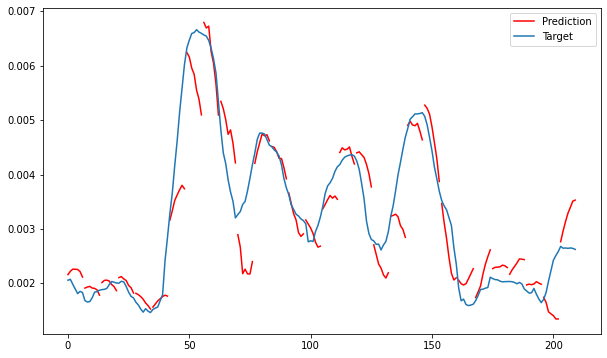

For look back window:21, forward days/horizon:7, the RMSE is: 0.0005273584741201638
   Look back  Horizon      RMSE
0        7.0      7.0  0.000721
1        7.0     14.0  0.000723
2        7.0     21.0  0.001686
3        7.0     28.0  0.001296
4       14.0      7.0  0.000552
5       14.0     14.0  0.000766
6       14.0     21.0  0.001516
7       14.0     28.0  0.001017
8       21.0      7.0  0.000527
=====FORECASTING VOLATILITY WITH 21 DAYS WINDOW AND 14 DAYS HORIZON=====
Epoch 1/50
2611/2611 - 18s - loss: 0.0131 - val_loss: 0.0081 - 18s/epoch - 7ms/step
Epoch 2/50
2611/2611 - 14s - loss: 0.0080 - val_loss: 0.0071 - 14s/epoch - 5ms/step
Epoch 3/50
2611/2611 - 13s - loss: 0.0070 - val_loss: 0.0070 - 13s/epoch - 5ms/step
Epoch 4/50
2611/2611 - 13s - loss: 0.0064 - val_loss: 0.0056 - 13s/epoch - 5ms/step
Epoch 5/50
2611/2611 - 13s - loss: 0.0061 - val_loss: 0.0061 - 13s/epoch - 5ms/step
Epoch 6/50
2611/2611 - 13s - loss: 0.0057 - val_loss: 0.0059 - 13s/epoch - 5ms/step
Epoch 7/50
2611/261

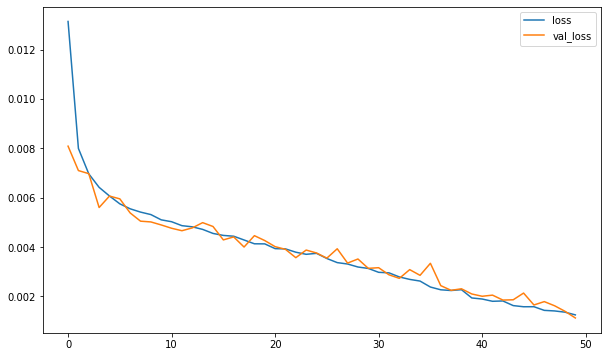

1/1 [==============================] - 1s 843ms/step


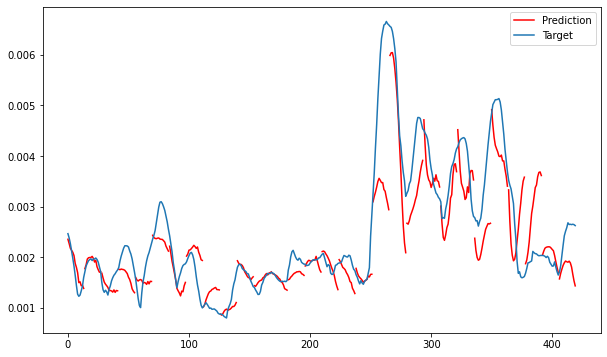

For look back window:21, forward days/horizon:14, the RMSE is: 0.0006817432141913403
   Look back  Horizon      RMSE
0        7.0      7.0  0.000721
1        7.0     14.0  0.000723
2        7.0     21.0  0.001686
3        7.0     28.0  0.001296
4       14.0      7.0  0.000552
5       14.0     14.0  0.000766
6       14.0     21.0  0.001516
7       14.0     28.0  0.001017
8       21.0      7.0  0.000527
9       21.0     14.0  0.000682
=====FORECASTING VOLATILITY WITH 21 DAYS WINDOW AND 21 DAYS HORIZON=====
Epoch 1/50
2437/2437 - 16s - loss: 0.0156 - val_loss: 0.0111 - 16s/epoch - 7ms/step
Epoch 2/50
2437/2437 - 12s - loss: 0.0114 - val_loss: 0.0127 - 12s/epoch - 5ms/step
Epoch 3/50
2437/2437 - 12s - loss: 0.0103 - val_loss: 0.0104 - 12s/epoch - 5ms/step
Epoch 4/50
2437/2437 - 12s - loss: 0.0098 - val_loss: 0.0086 - 12s/epoch - 5ms/step
Epoch 5/50
2437/2437 - 12s - loss: 0.0094 - val_loss: 0.0083 - 12s/epoch - 5ms/step
Epoch 6/50
2437/2437 - 12s - loss: 0.0087 - val_loss: 0.0073 - 12s/epo

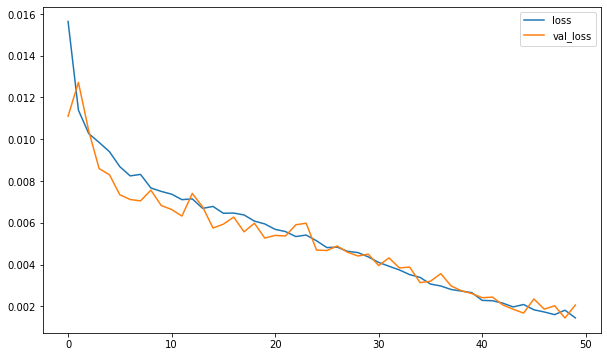

1/1 [==============================] - 1s 777ms/step


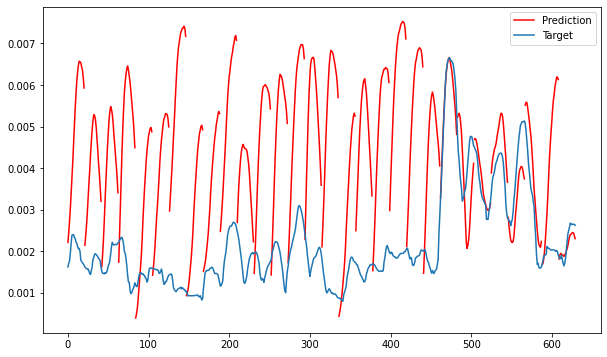

For look back window:21, forward days/horizon:21, the RMSE is: 0.0027909038102021883
    Look back  Horizon      RMSE
0         7.0      7.0  0.000721
1         7.0     14.0  0.000723
2         7.0     21.0  0.001686
3         7.0     28.0  0.001296
4        14.0      7.0  0.000552
5        14.0     14.0  0.000766
6        14.0     21.0  0.001516
7        14.0     28.0  0.001017
8        21.0      7.0  0.000527
9        21.0     14.0  0.000682
10       21.0     21.0  0.002791
=====FORECASTING VOLATILITY WITH 21 DAYS WINDOW AND 28 DAYS HORIZON=====
Epoch 1/50
2264/2264 - 15s - loss: 0.0157 - val_loss: 0.0122 - 15s/epoch - 7ms/step
Epoch 2/50
2264/2264 - 11s - loss: 0.0127 - val_loss: 0.0112 - 11s/epoch - 5ms/step
Epoch 3/50
2264/2264 - 11s - loss: 0.0115 - val_loss: 0.0120 - 11s/epoch - 5ms/step
Epoch 4/50
2264/2264 - 11s - loss: 0.0110 - val_loss: 0.0104 - 11s/epoch - 5ms/step
Epoch 5/50
2264/2264 - 11s - loss: 0.0106 - val_loss: 0.0096 - 11s/epoch - 5ms/step
Epoch 6/50
2264/2264 - 11s

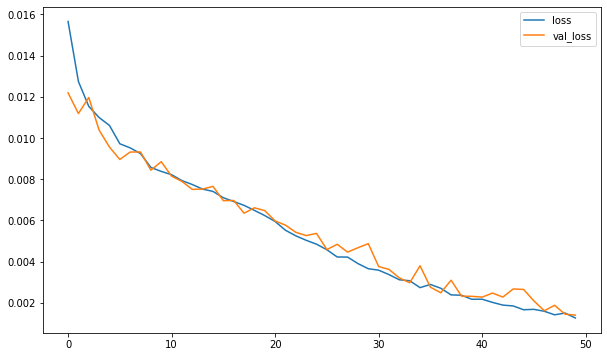

1/1 [==============================] - 1s 884ms/step


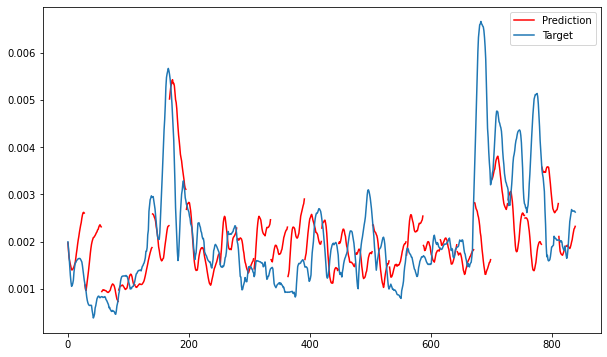

For look back window:21, forward days/horizon:28, the RMSE is: 0.0010764775969025107
    Look back  Horizon      RMSE
0         7.0      7.0  0.000721
1         7.0     14.0  0.000723
2         7.0     21.0  0.001686
3         7.0     28.0  0.001296
4        14.0      7.0  0.000552
5        14.0     14.0  0.000766
6        14.0     21.0  0.001516
7        14.0     28.0  0.001017
8        21.0      7.0  0.000527
9        21.0     14.0  0.000682
10       21.0     21.0  0.002791
11       21.0     28.0  0.001076
=====FORECASTING VOLATILITY WITH 28 DAYS WINDOW AND 7 DAYS HORIZON=====
Epoch 1/50
2779/2779 - 19s - loss: 0.0077 - val_loss: 0.0031 - 19s/epoch - 7ms/step
Epoch 2/50
2779/2779 - 14s - loss: 0.0035 - val_loss: 0.0025 - 14s/epoch - 5ms/step
Epoch 3/50
2779/2779 - 15s - loss: 0.0028 - val_loss: 0.0022 - 15s/epoch - 5ms/step
Epoch 4/50
2779/2779 - 14s - loss: 0.0026 - val_loss: 0.0021 - 14s/epoch - 5ms/step
Epoch 5/50
2779/2779 - 14s - loss: 0.0026 - val_loss: 0.0023 - 14s/epoch - 5ms

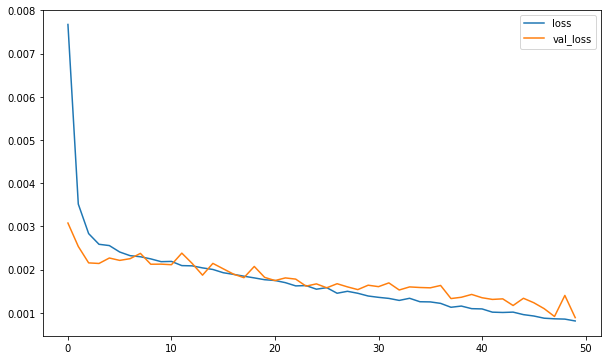

1/1 [==============================] - 1s 867ms/step


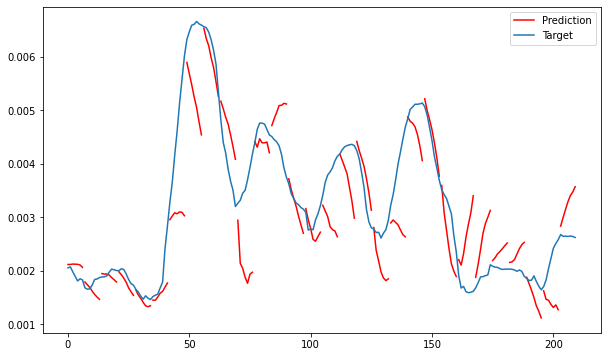

For look back window:28, forward days/horizon:7, the RMSE is: 0.000704905129766145
    Look back  Horizon      RMSE
0         7.0      7.0  0.000721
1         7.0     14.0  0.000723
2         7.0     21.0  0.001686
3         7.0     28.0  0.001296
4        14.0      7.0  0.000552
5        14.0     14.0  0.000766
6        14.0     21.0  0.001516
7        14.0     28.0  0.001017
8        21.0      7.0  0.000527
9        21.0     14.0  0.000682
10       21.0     21.0  0.002791
11       21.0     28.0  0.001076
12       28.0      7.0  0.000705
=====FORECASTING VOLATILITY WITH 28 DAYS WINDOW AND 14 DAYS HORIZON=====
Epoch 1/50
2605/2605 - 18s - loss: 0.0122 - val_loss: 0.0074 - 18s/epoch - 7ms/step
Epoch 2/50
2605/2605 - 13s - loss: 0.0079 - val_loss: 0.0081 - 13s/epoch - 5ms/step
Epoch 3/50
2605/2605 - 14s - loss: 0.0069 - val_loss: 0.0057 - 14s/epoch - 5ms/step
Epoch 4/50
2605/2605 - 13s - loss: 0.0064 - val_loss: 0.0052 - 13s/epoch - 5ms/step
Epoch 5/50
2605/2605 - 13s - loss: 0.0063 - va

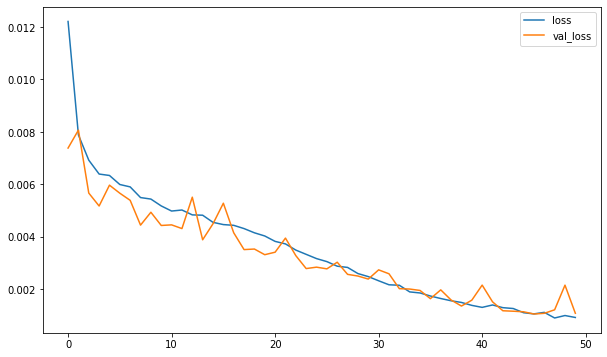

1/1 [==============================] - 1s 841ms/step


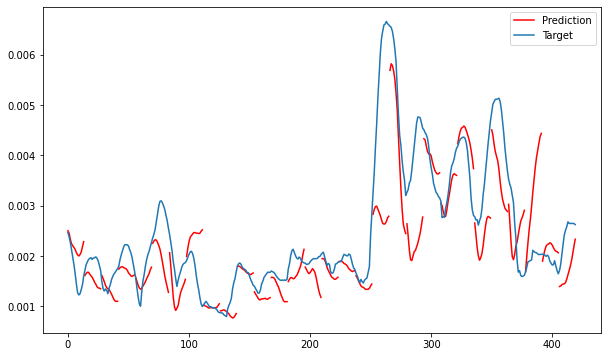

For look back window:28, forward days/horizon:14, the RMSE is: 0.0008475111563079901
    Look back  Horizon      RMSE
0         7.0      7.0  0.000721
1         7.0     14.0  0.000723
2         7.0     21.0  0.001686
3         7.0     28.0  0.001296
4        14.0      7.0  0.000552
5        14.0     14.0  0.000766
6        14.0     21.0  0.001516
7        14.0     28.0  0.001017
8        21.0      7.0  0.000527
9        21.0     14.0  0.000682
10       21.0     21.0  0.002791
11       21.0     28.0  0.001076
12       28.0      7.0  0.000705
13       28.0     14.0  0.000848
=====FORECASTING VOLATILITY WITH 28 DAYS WINDOW AND 21 DAYS HORIZON=====
Epoch 1/50
2432/2432 - 17s - loss: 0.0161 - val_loss: 0.0111 - 17s/epoch - 7ms/step
Epoch 2/50
2432/2432 - 13s - loss: 0.0115 - val_loss: 0.0098 - 13s/epoch - 5ms/step
Epoch 3/50
2432/2432 - 12s - loss: 0.0102 - val_loss: 0.0107 - 12s/epoch - 5ms/step
Epoch 4/50
2432/2432 - 13s - loss: 0.0098 - val_loss: 0.0080 - 13s/epoch - 5ms/step
Epoch 5/50


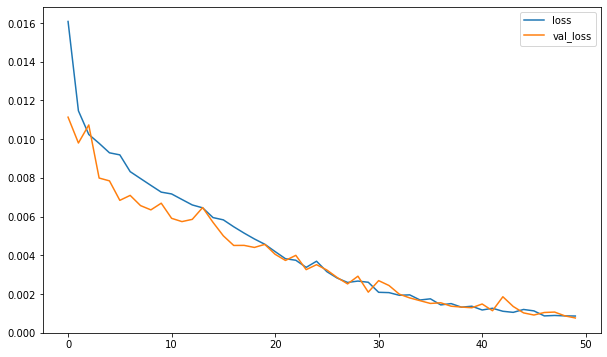

1/1 [==============================] - 1s 908ms/step


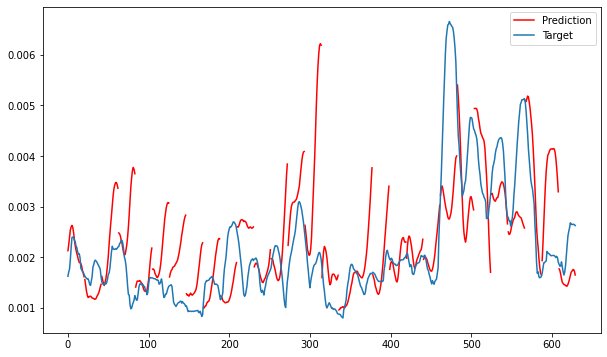

For look back window:28, forward days/horizon:21, the RMSE is: 0.0010075671312251677
    Look back  Horizon      RMSE
0         7.0      7.0  0.000721
1         7.0     14.0  0.000723
2         7.0     21.0  0.001686
3         7.0     28.0  0.001296
4        14.0      7.0  0.000552
5        14.0     14.0  0.000766
6        14.0     21.0  0.001516
7        14.0     28.0  0.001017
8        21.0      7.0  0.000527
9        21.0     14.0  0.000682
10       21.0     21.0  0.002791
11       21.0     28.0  0.001076
12       28.0      7.0  0.000705
13       28.0     14.0  0.000848
14       28.0     21.0  0.001008
=====FORECASTING VOLATILITY WITH 28 DAYS WINDOW AND 28 DAYS HORIZON=====
Epoch 1/50
2258/2258 - 16s - loss: 0.0159 - val_loss: 0.0120 - 16s/epoch - 7ms/step
Epoch 2/50
2258/2258 - 12s - loss: 0.0125 - val_loss: 0.0142 - 12s/epoch - 5ms/step
Epoch 3/50
2258/2258 - 12s - loss: 0.0115 - val_loss: 0.0106 - 12s/epoch - 5ms/step
Epoch 4/50
2258/2258 - 12s - loss: 0.0109 - val_loss: 0.0105 -

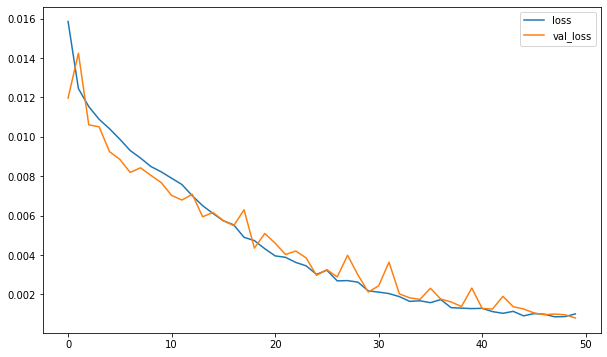

1/1 [==============================] - 1s 829ms/step


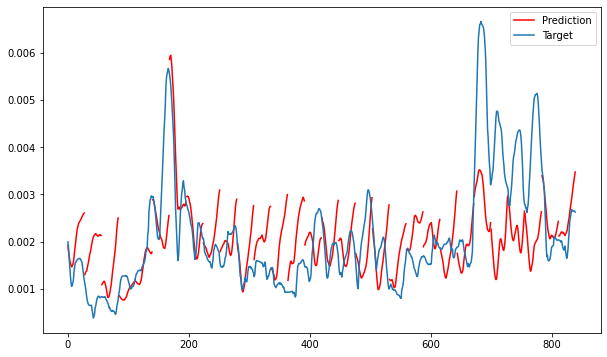

For look back window:28, forward days/horizon:28, the RMSE is: 0.0010362122918262332
    Look back  Horizon      RMSE
0         7.0      7.0  0.000721
1         7.0     14.0  0.000723
2         7.0     21.0  0.001686
3         7.0     28.0  0.001296
4        14.0      7.0  0.000552
5        14.0     14.0  0.000766
6        14.0     21.0  0.001516
7        14.0     28.0  0.001017
8        21.0      7.0  0.000527
9        21.0     14.0  0.000682
10       21.0     21.0  0.002791
11       21.0     28.0  0.001076
12       28.0      7.0  0.000705
13       28.0     14.0  0.000848
14       28.0     21.0  0.001008
15       28.0     28.0  0.001036


In [ ]:
# Predict Amazon stock using LSTM with different Window and Horizon.
# The end result shows that 14 days Window and 7 days Horizon perform the best.

array_AMZN = df_AMZN.values
evaluation_AMZN = predict_stock(array_AMZN)

# Main Body (Autoencoder)

Extracting 1 latent dimension from LSTM Autoencoder
Epoch 1/100
44/44 [==============================] - 4s 22ms/step - loss: 0.0508 - val_loss: 0.1747
Epoch 2/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0170 - val_loss: 0.1696
Epoch 3/100
44/44 [==============================] - 0s 6ms/step - loss: 0.0134 - val_loss: 0.1223
Epoch 4/100
44/44 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 0.0625
Epoch 5/100
44/44 [==============================] - 0s 6ms/step - loss: 0.0060 - val_loss: 0.0598
Epoch 6/100
44/44 [==============================] - 0s 6ms/step - loss: 0.0055 - val_loss: 0.0491
Epoch 7/100
44/44 [==============================] - 0s 9ms/step - loss: 0.0053 - val_loss: 0.0431
Epoch 8/100
44/44 [==============================] - 0s 9ms/step - loss: 0.0050 - val_loss: 0.0410
Epoch 9/100
44/44 [==============================] - 0s 9ms/step - loss: 0.0049 - val_loss: 0.0346
Epoch 10/100
44/44 [==============================] - 0s

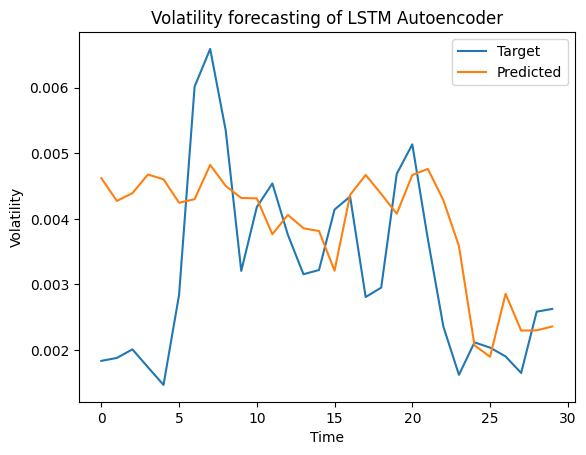

Extracting 2 latent dimension from LSTM Autoencoder
Epoch 1/100
44/44 [==============================] - 7s 47ms/step - loss: 0.0504 - val_loss: 0.1991
Epoch 2/100
44/44 [==============================] - 0s 6ms/step - loss: 0.0162 - val_loss: 0.1837
Epoch 3/100
44/44 [==============================] - 0s 6ms/step - loss: 0.0115 - val_loss: 0.0979
Epoch 4/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0060 - val_loss: 0.0540
Epoch 5/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0040 - val_loss: 0.0478
Epoch 6/100
44/44 [==============================] - 0s 6ms/step - loss: 0.0035 - val_loss: 0.0418
Epoch 7/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0033 - val_loss: 0.0379
Epoch 8/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0032 - val_loss: 0.0367
Epoch 9/100
44/44 [==============================] - 0s 6ms/step - loss: 0.0031 - val_loss: 0.0368
Epoch 10/100
44/44 [==============================] - 0s

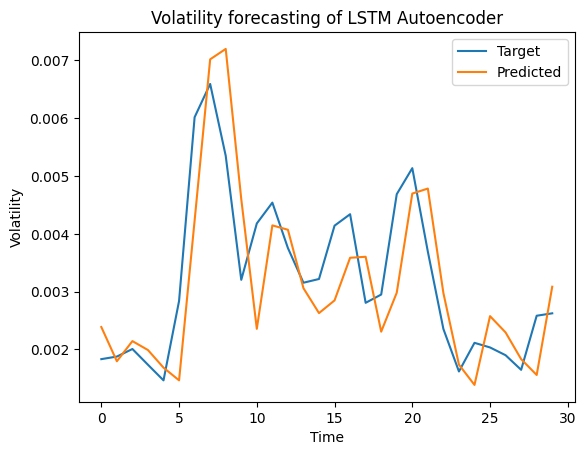

Extracting 3 latent dimension from LSTM Autoencoder
Epoch 1/100
44/44 [==============================] - 5s 22ms/step - loss: 0.0321 - val_loss: 0.1557
Epoch 2/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0087 - val_loss: 0.0907
Epoch 3/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0058 - val_loss: 0.0696
Epoch 4/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0052 - val_loss: 0.0592
Epoch 5/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0048 - val_loss: 0.0536
Epoch 6/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0046 - val_loss: 0.0495
Epoch 7/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0043 - val_loss: 0.0426
Epoch 8/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0040 - val_loss: 0.0401
Epoch 9/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0036 - val_loss: 0.0321
Epoch 10/100
44/44 [==============================] - 0s

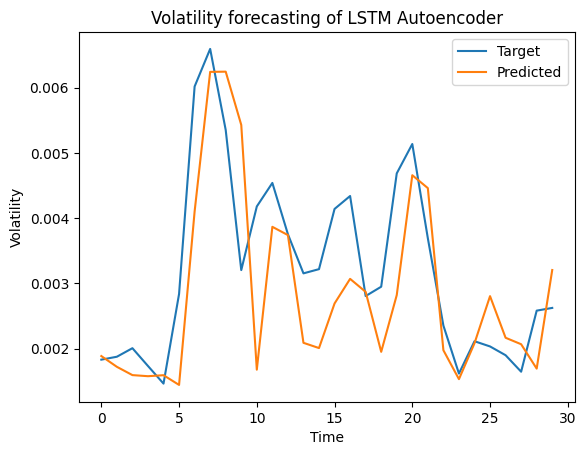

Extracting 4 latent dimension from LSTM Autoencoder
Epoch 1/100
44/44 [==============================] - 6s 23ms/step - loss: 0.0477 - val_loss: 0.1110
Epoch 2/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0062 - val_loss: 0.0831
Epoch 3/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0037 - val_loss: 0.0538
Epoch 4/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0027 - val_loss: 0.0378
Epoch 5/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0022 - val_loss: 0.0298
Epoch 6/100
44/44 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0241
Epoch 7/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 0.0213
Epoch 8/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0191
Epoch 9/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0164
Epoch 10/100
44/44 [==============================] - 0s

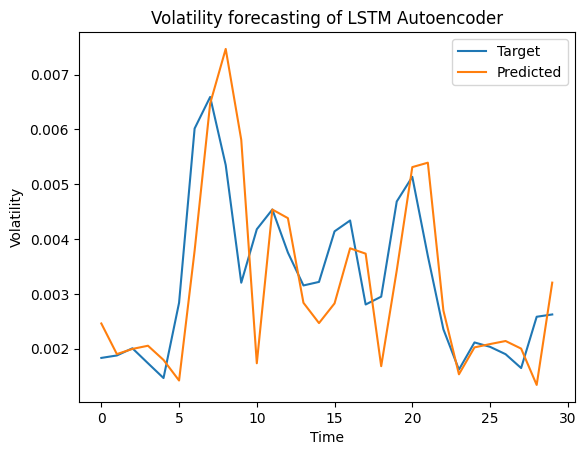

Extracting 5 latent dimension from LSTM Autoencoder
Epoch 1/100
44/44 [==============================] - 5s 22ms/step - loss: 0.0538 - val_loss: 0.1157
Epoch 2/100
44/44 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0436
Epoch 3/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0038 - val_loss: 0.0361
Epoch 4/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0035 - val_loss: 0.0336
Epoch 5/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0032 - val_loss: 0.0321
Epoch 6/100
44/44 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0292
Epoch 7/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0025 - val_loss: 0.0258
Epoch 8/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0022 - val_loss: 0.0222
Epoch 9/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 0.0199
Epoch 10/100
44/44 [==============================] - 0s

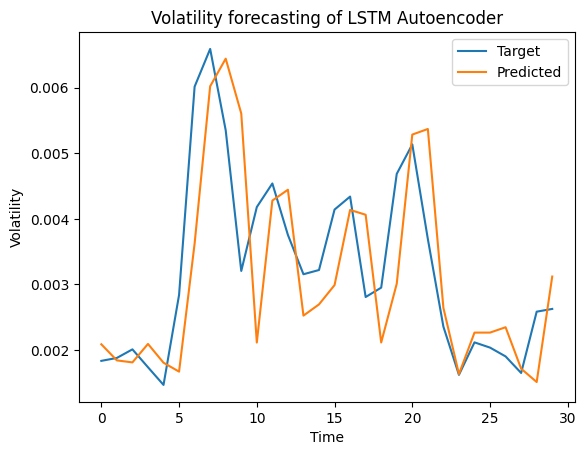

Extracting 6 latent dimension from LSTM Autoencoder
Epoch 1/100
44/44 [==============================] - 4s 22ms/step - loss: 0.0296 - val_loss: 0.1197
Epoch 2/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0059 - val_loss: 0.0619
Epoch 3/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0034 - val_loss: 0.0433
Epoch 4/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0025 - val_loss: 0.0274
Epoch 5/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 0.0201
Epoch 6/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0181
Epoch 7/100
44/44 [==============================] - 0s 10ms/step - loss: 0.0011 - val_loss: 0.0168
Epoch 8/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0010 - val_loss: 0.0164
Epoch 9/100
44/44 [==============================] - 0s 7ms/step - loss: 9.7238e-04 - val_loss: 0.0148
Epoch 10/100
44/44 [==============================]

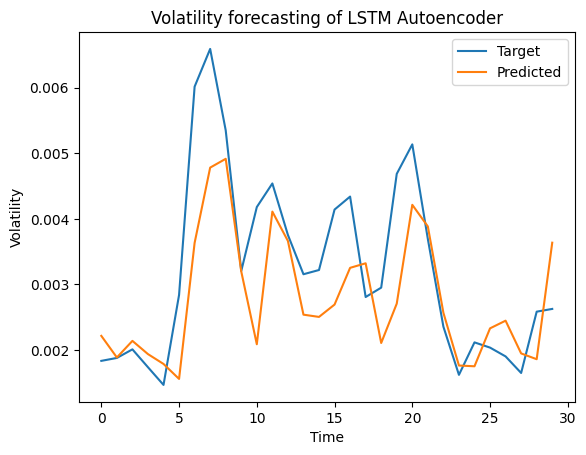

In [24]:
# Extracting LSTM Autoencoder
latent_dim_list = [1,2,3,4,5,6]
all_rmse_auto_lstm = []
for latent_dim in latent_dim_list:
  print(f"Extracting {latent_dim} latent dimension from LSTM Autoencoder")
  rmse_auto_lstm = lstm_autoencoder(df_AMZN, latent_dim)
  all_rmse_auto_lstm.append(rmse_auto_lstm)

# Main Body (Cross-Validation)

In [ ]:
# Evaluate the model performance by time series cross validation

AMZN_cv_rmse = lstm_cross_validation(df_AMZN)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None)
##############################################################
Fold 1:
TRAIN: 338 TEST: 338
----------------------------------------------------------------------
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
11/11 [==============================] - 1s 3ms/step
testScore: 0.0021905911438254533
Fold 2:
TRAIN: 676 TEST: 338
----------------------------------------------------------------------
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
11/11 [==============================] - 1s 3ms/step
testScore: 0.0019666725496943287
Fold 3:
TRAIN: 101

In [ ]:
# Evaluate the model performance by time series cross validation

AAPL_cv_rmse = lstm_cross_validation(df_AAPL)
MSFT_cv_rmse = lstm_cross_validation(df_MSFT)
GOOGL_cv_rmse = lstm_cross_validation(df_GOOGL)
NVDA_cv_rmse = lstm_cross_validation(df_NVDA)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None)
##############################################################
Fold 1:
TRAIN: 338 TEST: 338
----------------------------------------------------------------------
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
11/11 [==============================] - 1s 4ms/step
testScore: 0.0013022151756583496
Fold 2:
TRAIN: 676 TEST: 338
----------------------------------------------------------------------
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10

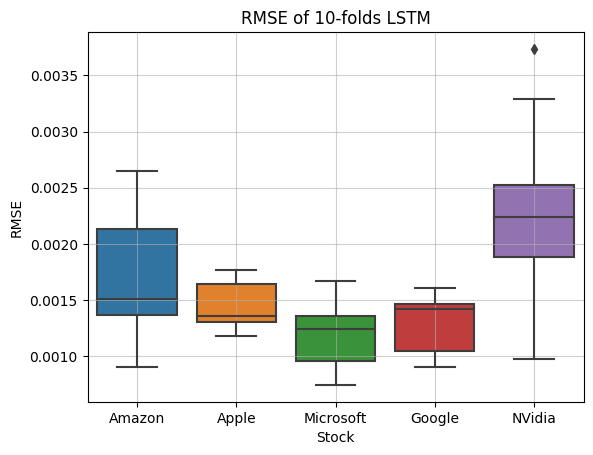

In [ ]:
# Plot the box plot for RMSE
both_rmse = [AMZN_cv_rmse, AAPL_cv_rmse, MSFT_cv_rmse, GOOGL_cv_rmse, NVDA_cv_rmse]
names = ["Amazon", "Apple", "Microsoft", "Google", "NVidia"]
sns.boxplot(data=both_rmse)
plt.xticks(range(len(both_rmse)), names)
plt.xlabel('Stock')
plt.title('RMSE of 10-folds LSTM')
plt.ylabel('RMSE')
plt.grid(alpha=0.6)
plt.show()

# Main Body (Ensemble Method)

In [ ]:
# XGBoost Regressor

AMZN_cv_rmse_xg = xgboost_cross_validation(df_AMZN)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None)
##############################################################
Fold 1:
TRAIN: 338 TEST: 338
----------------------------------------------------------------------
testScore: 0.002168695674319976
Fold 2:
TRAIN: 676 TEST: 338
----------------------------------------------------------------------
testScore: 0.001892971341810128
Fold 3:
TRAIN: 1014 TEST: 338
----------------------------------------------------------------------
testScore: 0.0012235721590560169
Fold 4:
TRAIN: 1352 TEST: 338
----------------------------------------------------------------------
testScore: 0.001469020336180479
Fold 5:
TRAIN: 1690 TEST: 338
----------------------------------------------------------------------
testScore: 0.002277679059755617
Fold 6:
TRAIN: 2028 TEST: 338
----------------------------------------------------------------------
testScore: 0.0009232932473687745
Fold 7:
TRAIN: 2366 TEST: 338
------------------------------------

In [ ]:
# Random Forests Regressor

AMZN_cv_rmse_rf = randomforest_cross_validation(df_AMZN)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None)
##############################################################
Fold 1:
TRAIN: 338 TEST: 338
----------------------------------------------------------------------
testScore: 0.002168875400995704
Fold 2:
TRAIN: 676 TEST: 338
----------------------------------------------------------------------
testScore: 0.0018930894280222196
Fold 3:
TRAIN: 1014 TEST: 338
----------------------------------------------------------------------
testScore: 0.0012239023203897766
Fold 4:
TRAIN: 1352 TEST: 338
----------------------------------------------------------------------
testScore: 0.0014691112431240488
Fold 5:
TRAIN: 1690 TEST: 338
----------------------------------------------------------------------
testScore: 0.0022776836229082245
Fold 6:
TRAIN: 2028 TEST: 338
----------------------------------------------------------------------
testScore: 0.0009235273692690688
Fold 7:
TRAIN: 2366 TEST: 338
---------------------------------

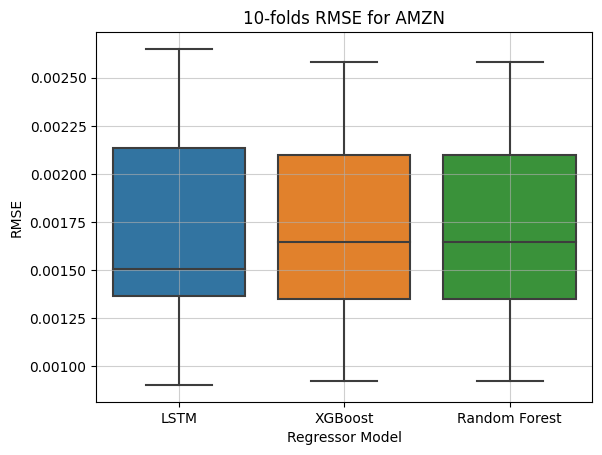

In [ ]:
# Plot the box plot for RMSE
both_rmse = [AMZN_cv_rmse, AMZN_cv_rmse_xg, AMZN_cv_rmse_rf]
names = ["LSTM", "XGBoost", "Random Forest"]
sns.boxplot(data=both_rmse)
plt.xticks(range(len(both_rmse)), names)
plt.xlabel('Regressor Model')
plt.title('10-folds RMSE for AMZN')
plt.ylabel('RMSE')
plt.grid(alpha=0.6)
plt.show()